# Magic BERT
#### Investigating the similarity of MtG flavor text with a large language model

We will be using the [Sentence-BERT](https://arxiv.org/abs/1908.10084) (SBERT) model, which has been pretrained and optimized for finding similarities in text. It is designed to provide meaningful embeddings of sentences such that outputs with low cosine distance will have very similar semantic content. To do so we will create a sentence-transformer using the [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) model, which according to the experts at [SBERT](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models) has the highest performance on these types of tasks.

---

This notebook is based off of the [NLP Course](https://huggingface.co/learn/nlp-course/en) from HuggingFace and [this Geeks for Geeks post](https://www.geeksforgeeks.org/sentence-similarity-using-bert-transformer/).


In [2]:
import numpy as np
import torch

# Create Model Object
from sentence_transformers import SentenceTransformer
# device = torch.device("mps")
model = SentenceTransformer("all-mpnet-base-v2",device='mps')

/Users/gordonpetty/opt/anaconda3/envs/ernie/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Let's make up some flavor text! We will then run it through our model to see which are the most similar. 
Here I am writing two sentences about goblins and their odor, which should have a high similarity metric. The other two sentences are meant to sound like generic flavor text from Blue or Black cards, and should be dissimilar to each other and the two lines about Goblins. 

In [3]:
my_flavor_text = ["Goblins sure do smell bad.",
    "Those goblins are loud and offensive!",
    "The mind is the purest distillation of progress.",
    "My power over death makes me unstoppable"]

In [4]:
# By default the model uses Cosine Similarity as the similarity metric.
embeddings = model.encode(my_flavor_text)
similarities = model.similarity(embeddings,embeddings)
print(similarities)

tensor([[ 1.0000,  0.6725,  0.0113,  0.0721],
        [ 0.6725,  1.0000, -0.0032,  0.1065],
        [ 0.0113, -0.0032,  1.0000,  0.2725],
        [ 0.0721,  0.1065,  0.2725,  1.0000]])


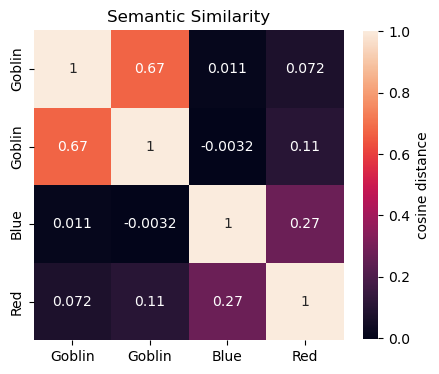

In [5]:
# Next we can visualize the similarities with a heat map matrix using Seaborn
import seaborn as sns
from matplotlib import pyplot as plt

labels = ['Goblin','Goblin','Blue','Red']
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(similarities, annot=True,
            xticklabels=labels,yticklabels=labels,
            square=True,cbar_kws={'shrink':0.8,'label':'cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

As expected, the first two lines of text are very similar to eachother, while the remaining two are relatively dissimilar.

## Now, let's take a look at actual flavor text! 

Our hypothesis is that red cards will be most similar to other red cards, blue cards similar to other blue cards, and so forth.
To reduce computation time and simplify visualization, we will start with 500 cards: 100 monocolored cards from each of the five colors. 

In [6]:
# Load card data
# - We downloaded this earlier in the Colorful_Flavor notebook
import pickle
import pandas as pd
datapath = 'card_data/CardData.pkl'
with open(datapath,'rb') as file:    
    data = pickle.load(file)

# Simplify dataframe to relevant information
data = data.loc[:,['name','type_line','set','mana_cost','colors','flavor_text']].reset_index(drop=True)

# Identify monocolored cards
is_monocolored = data['colors'].apply(lambda x : np.shape(x) == (1,))
data['monocolored'] = is_monocolored

In [7]:
# Subset 100 random monocolored cards from each color
# Set a random seed for replicability:
np.random.seed(31)
colors = ['W','U','B','R','G']
mono_cards = data.loc[data['monocolored'],:]
# Drop repeated cards, as some of them have repeated flavor text in slightly different formatting.
# Pandas "duplicates" can't find this, simply dropping duplicate cards is aggressive but will ensure no duplicate flavor text
mono_cards = mono_cards.drop_duplicates(subset ='name')
card_subsample = pd.concat([mono_cards.loc[mono_cards['colors'].explode() == color,:].sample(100) for color in colors])
card_subsample = card_subsample.reset_index(drop=True)
print('Some example monocolored cards')
card_subsample.sample(10)

Some example monocolored cards


,name,type_line,set,mana_cost,colors,flavor_text,monocolored
496,Pinion Feast,Instant,dtk,{4}{G},[G],"""even paradise is not without tragedies.""\n—sa...",True
196,Hive Mind,Enchantment,sld,{5}{U},[U],"in an instant, countless consciousnesses share...",True
371,Cinder Crawler,Creature — Salamander,exo,{1}{R},[R],the crawler doesn't care what gets in its way....,True
252,Drekavac,Creature — Beast,dis,{1}{B},[B],"like a vulture's scalp, the face of a drekavac...",True
388,Ricochet Trap,Instant — Trap,wwk,{3}{R},[R],"in his last seconds, remhas regretted using hi...",True
67,Sanctimony,Enchantment,7ed,{1}{W},[W],"""the peasants labor for my profit. i approve.""",True
113,Refocus,Instant,frf,{1}{U},[U],"""before you can open your third eye, you must ...",True
12,Earth-Origin Yak,Creature — Ox,pz2,{3}{W},[W],"deep in the northern mountains, the yaks linge...",True
312,Thunderbolt,Instant,avr,{1}{R},[R],"""my next aerial design will use less metal.""\n...",True
449,Crested Herdcaller,Creature — Dinosaur,gn2,{3}{G}{G},[G],"""our survival, like theirs, depends on our abi...",True


In [8]:
# Extract the flavor text column from our data frame and run it through our model
flavor_text_sample = card_subsample['flavor_text'].to_numpy()
embeddings = model.encode(flavor_text_sample)
similarities = model.similarity(embeddings,embeddings)


card_subsample['embedding'] = list(embeddings)

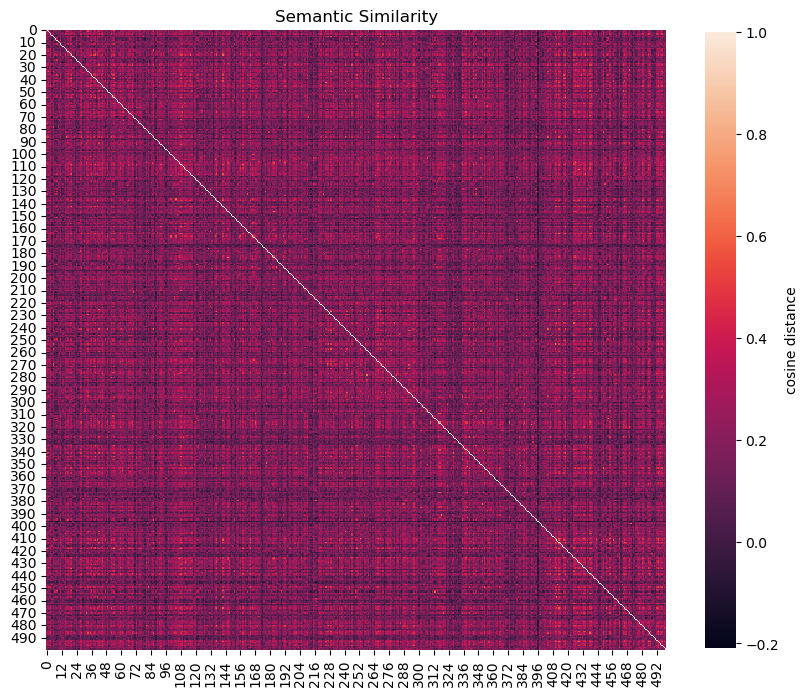

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(similarities, annot=False,
            square=True,cbar_kws={'shrink':0.8,'label':'cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

Despite putting the flavor text in order of color, there doesn't seem to be any underlying structure. That is to say, there are no obvious clusters of cards that might align with colors. 

Let's take a closer look at which cards are most and least similar

In [10]:
sim_np = similarities.numpy() # from tensor to np array
np.fill_diagonal(sim_np,0)
# Fill the upper triangle of the matrix with zeros so we don't get repeated pairs
sim_np = np.tril(sim_np)

In [11]:
# Look for the top 10 most similar pairs of text:
# Unravel similarities
sim_np_unravel = sim_np.reshape(-1)
x,y = np.unravel_index(np.argpartition(sim_np_unravel,-10),sim_np.shape)
# each x-y pair corresponds to a pair of flavor texts. 
# Iterate through them and print out each pair along with their similarity scores
# (Note that the scores are unsorted, but last 10 are guaranteed to be the top 10 highest scores)
x_top = x[-10:]
y_top = y[-10:]
# Sort descending:
coords = [(xx,yy) for xx,yy in zip(x[-10:],y[-10:])]
max_vals = [sim_np[x,y] for x,y in coords]
sort_order = np.flip(np.argsort(max_vals))
x_top = x_top[sort_order]
y_top = y_top[sort_order]
for i in range(len(x_top)):
    sim_score = float(sim_np[x_top[i]][y_top[i]])
    print(card_subsample['name'][x_top[i]],"    ",card_subsample['colors'][x_top[i]])
    print("   ",flavor_text_sample[x_top[i]])
    print("")
    print(card_subsample['name'][y_top[i]],"    ",card_subsample['colors'][y_top[i]])
    print("   ",flavor_text_sample[y_top[i]])
    print(" ")
    print(f"Similarity Score = {np.round(sim_score,3)}")
    print('---------------------------------------------')

Nantuko Husk      ['B']
    the soul sheds light, and death is its shadow. when the light dims, life and death embrace.
—nantuko teaching

Dauthi Slayer      ['B']
    "a wisp of life remains in the undergloom of death: a visible form, though no heart beats within it."
—homer, *the iliad*, trans. fitzgerald
 
Similarity Score = 0.708
---------------------------------------------
Goblin Assault Team      ['R']
    under the veneer of the various guilds, each goblin has the same basic need: to run screaming at the enemy and hit a bunch of stuff.

Krenko's Command      ['R']
    goblins are eager to follow orders, especially when those orders involve stealing, hurting, annoying, eating, destroying, or swearing.
 
Similarity Score = 0.705
---------------------------------------------
Goblin Grenade      ['R']
    "without their massive numbers, the goblins could never have launched such a successful offensive."
—*sarpadian empires, vol. vi*

Goblin Snowman      ['R']
    "strength in numbe

The vibes of these passages seem to line up well with eachother, but the colors of cards don't always align.\
It also appears that passages quoted by the same character are often paired together.\

In [11]:
# First replace all 0's with 1's so that we can still ignore the diagonal and upper triangle
# (here we don't bother sorting)
sim_np[sim_np == 0] = 1
x,y = np.unravel_index(np.argpartition(sim_np_unravel,5),sim_np.shape)
sim_np_unravel = sim_np.reshape(-1)
x_top = x[:5]
y_top = y[:5]
for i in range(len(x_top)):
    sim_score = float(sim_np[x_top[i]][y_top[i]])
    print(card_subsample['name'][x_top[i]],"    ",card_subsample['colors'][x_top[i]])
    print("   ",flavor_text_sample[x_top[i]])
    print("")
    print(card_subsample['name'][y_top[i]],"    ",card_subsample['colors'][y_top[i]])
    print("   ",flavor_text_sample[y_top[i]])
    print(" ")
    print(f"Similarity Score = {np.round(sim_score,3)}")
    print('---------------------------------------------')

Vigilant Drake      ['U']
    awake and awing in the blink of an eye.

Dauntless Dismantler      ['W']
    to their dismay, brazen coalition explorers soon found that the oltec were not impressed by cannons.
 
Similarity Score = -0.184
---------------------------------------------
Kami of Terrible Secrets      ['B']
    it feeds on things better left unknown, savoring the bitterness of lies and regrets.

Tasseled Dromedary      ['W']
    there is no dress code for the inventors' fair, but you'll be hard-pressed to find anyone or anything not done up in their finest.
 
Similarity Score = -0.176
---------------------------------------------
Spawning Grounds      ['G']
    it's the only water source in miles of desert, but the local tribes avoid it at all costs.

Vigilant Drake      ['U']
    awake and awing in the blink of an eye.
 
Similarity Score = -0.188
---------------------------------------------
Spawning Grounds      ['G']
    it's the only water source in miles of desert, but th

While it is difficult to say if these pairs are truly *disparate* in some way, they certainly different vibes than those flavor text pairs that are most similar.